In [110]:
import numpy as np
import cv2
import argparse
from random import shuffle
import matplotlib.pyplot as plt

In [111]:
class Individual:

    # shape = rectangular, circle, polygon, mixed.
    # img_size = 2-dimensional (height, width)
    def __init__(self, img_size, shape='circle', _res=10):
        self.shape_ = shape
        self.img_size_ = img_size
        self.shape_func_dict_ = {'line' : self.assign_line, 'circle' : self.assign_circle, 'rectangular' : self.assign_rect, 
                                'polygon' : self.assign_poly, 'mixed' : self.assign_mixed}
        self.nbr_of_vertices_ = 8
        self.shape_funct_list_ = ['line', 'circle', 'rectangular', 'polygon']
        self.fitness_ = 0
        self.image_ = None
        self.shape_list_ = []
        self.res_ = _res

        
    def create_random_image(self):
        self.image_ = np.zeros((self.img_size_[0], self.img_size_[1], 3), np.uint8)
        num_rand_shapes = int((self.img_size_[0] + self.img_size_[1]) / 20)
        
        for _ in range(num_rand_shapes):
            self.shape_func_dict_[self.shape_]()

            
    def assign_mixed(self):
        i = np.random.randint(0, len(self.shape_funct_list_))
        self.shape_func_dict_[self.shape_funct_list_[i]]()

        
    def assign_line(self):
        min_x = np.random.randint(0, self.img_size_[1])
        max_x = min_x + np.random.randint(-1, 2) * np.random.randint(5, int(self.img_size_[1] / 5.))
        min_y = np.random.randint(0, self.img_size_[0])
        max_y = min_y + np.random.randint(-1, 2) * np.random.randint(5, int(self.img_size_[0] / 5.))
        opacity = np.random.rand(1)[0]
        thickness = np.random.randint(1, 5)
        color = Individual.get_bgr_color()

        overlay = self.image_.copy()
        cv2.line(overlay, (min_x, min_y), (max_x, max_y), color, thickness)

        cv2.addWeighted(overlay, opacity, self.image_, 1 - opacity, 0, self.image_)

        
    def assign_circle(self):
        center_x = np.random.randint(0, self.img_size_[1])
        center_y = np.random.randint(0, self.img_size_[0])
        radius = np.random.randint(0, int(self.img_size_[0] / (1.1*self.res_)))
        opacity = np.random.rand(1)[0]
        color = Individual.get_bgr_color()

        overlay = self.image_.copy()
        cv2.circle(overlay, (center_x, center_y), radius, color, -1)

        cv2.addWeighted(overlay, opacity, self.image_, 1 - opacity, 0, self.image_)

        
    def assign_rect(self):
        min_x = np.random.randint(0, self.img_size_[1])
        max_x = min_x + np.random.randint(5, int(self.img_size_[1] / self.res_))
        min_y = np.random.randint(0, self.img_size_[0])
        max_y = min_y + np.random.randint(5, int(self.img_size_[0] / self.res_))
        opacity = np.random.rand(1)[0]
        color = Individual.get_bgr_color()

        overlay = self.image_.copy()
        cv2.rectangle(overlay, (min_x, min_y), (max_x, max_y), color, -1)

        cv2.addWeighted(overlay, opacity, self.image_, 1 - opacity, 0, self.image_)

        
    def assign_poly(self):
        pts = []
        point = [np.random.randint(0, self.img_size_[1]), 
                    np.random.randint(0, self.img_size_[0])]
        pts.append(point)

        for _ in range(self.nbr_of_vertices_-1):
            new_point = [point[0] + np.random.randint(-1, 2) * np.random.randint(0, int(self.img_size_[1] / self.res_)), 
                         point[1] + np.random.randint(-1, 2) * np.random.randint(0, int(self.img_size_[0] / self.res_))]
            pts.append(new_point)

        
        pts = np.array(pts)
        pts = pts.reshape((-1, 1, 2))
        opacity = np.random.rand(1)[0]
        color = Individual.get_bgr_color()

        overlay = self.image_.copy()

        cv2.fillPoly(overlay, [pts], color, 8)
        cv2.addWeighted(overlay, opacity, self.image_, 1 - opacity, 0 ,self.image_)

        
    def mutate(self, _max_mut_num):
        for i in range(np.random.randint(1, _max_mut_num)):
            self.shape_func_dict_[self.shape_]()
        
                       
    def show_image(self):
        plt.figure(figsize = (10,10))
        plt.imshow(self.image_)
        plt.title('Generated image')
        plt.show()
        
        
    def get_bgr_color():
        blue  = np.random.randint(0, 255)
        green = np.random.randint(0, 255)
        red   = np.random.randint(0, 255)
        return (blue, green, red)

In [112]:
class Genetic:
    # ind_config: shape, resolution
    def __init__(self, _pop_size, _image, _ind_config, _num_iterations = 250000, _mut_rate = 0.05, _max_mut_num = 100):
        self.pop_size_ = _pop_size
        self.image_ = _image
        self.num_iterations_ = _num_iterations
        self.max_distance_ = np.mean(np.abs(255 - self.image_))
        self.ind_config_ = _ind_config
        self.population_ = []
        self.mut_rate_ = _mut_rate
        self.max_mut_num = _max_mut_num
        
        self.best_ind_ = Individual(self.image_.shape[:-1], shape=self.ind_config_['shape'], _res=self.ind_config_['resolution'])
        self.best_ind_.create_random_image()
        self.create_population()


    def create_population(self):
        for _ in range(self.pop_size_):
            ind = Individual(self.image_.shape[:-1], shape=self.ind_config_['shape'], _res=self.ind_config_['resolution'])
            ind.create_random_image()
            self.population_.append(ind)


    def run(self):
        for i in range(self.num_iterations_):
            
            for index, individual in enumerate(self.population_):
                individual.fitness_ = self.get_fitness(index)
                if self.best_ind_.fitness_ < individual.fitness_:
                    self.best_ind_ = individual
                    
            self.create_percentage_pool()
            
            new_pop = []
            for j in range(self.pop_size_):
                parent_1 = self.random_selection()
                parent_2 = self.random_selection()
                child = self.reproduce(parent_1, parent_2)
                if (np.random.rand() < self.mut_rate_):
                    child.mutate(self.max_mut_num)
                new_pop.append(child)
                
            self.population_ = new_pop
            
            if i % 100 == 0:
                print(f"Step {i}, Best Fitness: {round(self.best_ind_.fitness_, 4)}\n")
                
                self.best_ind_.show_image()
                self.save_best_ind(i)


    def random_selection(self):
        ind = self.pop_percentage_pool_[np.random.randint(0, len(self.pop_percentage_pool_))]
        return self.population_[ind]


    def reproduce(self, parent_1, parent_2):
        child = Individual(self.image_.shape[:-1], shape=self.ind_config_['shape'], _res=self.ind_config_['resolution'])
        child.image_ = np.zeros((self.image_.shape), dtype=np.uint8)
        parents_ratio = np.random.rand()
        cv2.addWeighted(parent_1.image_, parents_ratio, parent_2.image_, 1 - parents_ratio, 0, child.image_)
        return child
            
                
    def get_fitness(self, index):
        dist = np.mean(np.abs(self.image_ - self.population_[index].image_)) / self.max_distance_
        fitness = 1 - dist    
        return fitness


    def create_percentage_pool(self):
        self.pop_percentage_pool_ = []
        for index, individual in enumerate(self.population_):
            self.pop_percentage_pool_ += [index] * int(individual.fitness_ * 100)
        shuffle(self.pop_percentage_pool_)

        
    def save_best_ind(self, step):
        con = np.concatenate((self.image_, self.best_ind_.image_), axis=1)
        cv2.imwrite("output/Step_" + str(step) + "_Fitness_" + str(self.best_ind_.fitness_) + ".jpg", con)

In [113]:
image = cv2.imread('images/test.jpg')

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [114]:
shape = "mixed"
pop_size = 25
    
genetic = Genetic(pop_size, image, {'shape': shape, 'resolution':25.}, _num_iterations = 500, _mut_rate = 1.)

Step 0, Best Fitness: 0.4981

[21, 13, 17, 13, 0, 9, 19, 7, 4, 15, 24, 9, 4, 22, 0, 23, 6, 2, 15, 4, 12, 18, 0, 13, 20, 3, 10, 13, 3, 16]


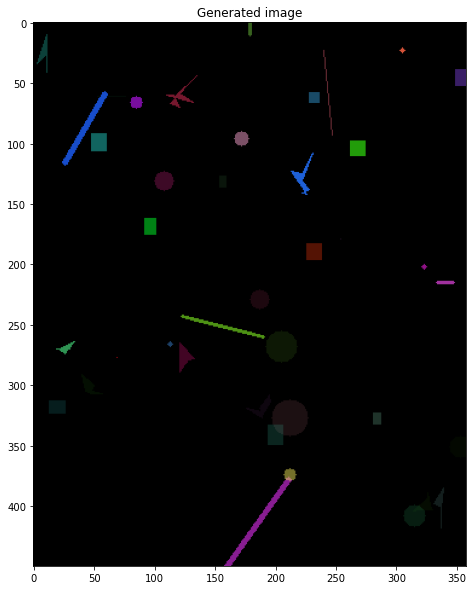

Step 100, Best Fitness: 0.5098

[17, 4, 11, 1, 22, 14, 15, 18, 6, 11, 6, 0, 1, 3, 24, 19, 13, 21, 21, 5, 3, 5, 22, 17, 19, 15, 20, 1, 19, 16]


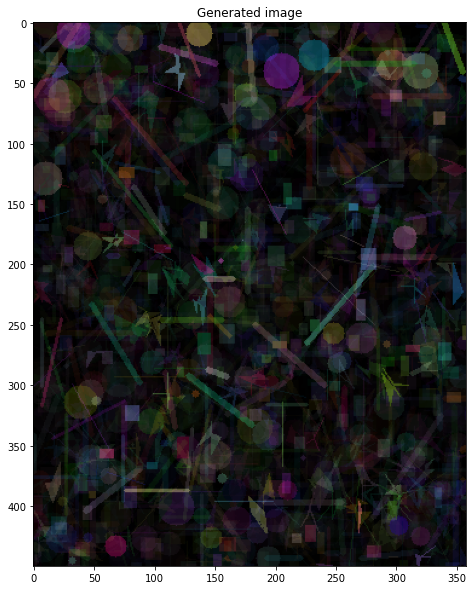

Step 200, Best Fitness: 0.5098

[1, 22, 6, 1, 19, 0, 17, 7, 24, 4, 6, 17, 17, 4, 11, 10, 12, 22, 17, 23, 11, 5, 19, 7, 13, 14, 18, 15, 2, 1]


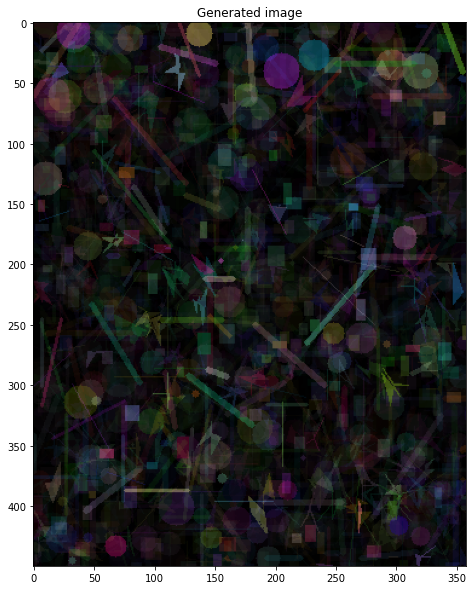

Step 300, Best Fitness: 0.5098

[8, 23, 8, 13, 17, 21, 7, 22, 2, 6, 21, 18, 5, 10, 22, 19, 4, 7, 13, 19, 5, 15, 16, 18, 14, 14, 6, 18, 0, 2]


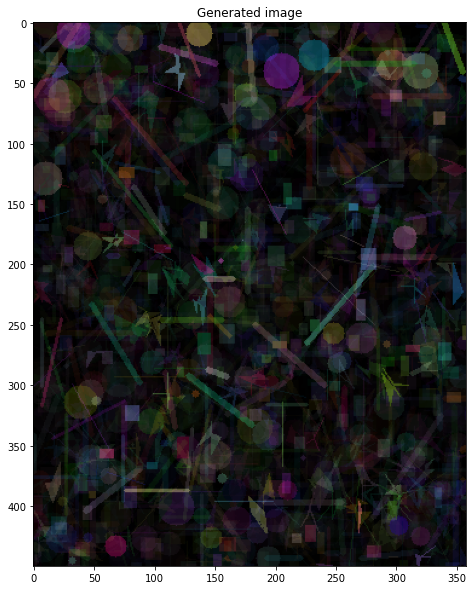

KeyboardInterrupt: 

In [115]:
genetic.run()